### Import Libraries

In [224]:
import numpy as np
import seaborn as sns
from datetime import datetime
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
from scipy import stats
import ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Read in stock data

In [225]:

symbol = "SPY"
period = "1y"
stock_data = yf.download(symbol, period = period)

[*********************100%%**********************]  1 of 1 completed


### Create ta-lib technical analysis indicators in dataframe

### Bollinger Bands Simple Implementation
- price above top band 
- price b/w top and mid band
- price below bot band
- price b/w bot and mid band

In [226]:
# Calculate Bollinger Bands
stock_data['upper_bol_band'], stock_data['mid_bol_band'], stock_data['lower_bol_band'] = talib.BBANDS(stock_data['Close'])

In [227]:
# Initialize cols with 0s
stock_data['above_upper_bol_band'] = 0
stock_data['btw_upper_mid_bol_band'] = 0
stock_data['btw_lower_mid_bol_band'] = 0
stock_data['below_lower_bol_band'] = 0

stock_data.loc[stock_data['High'] >= stock_data['upper_bol_band'], 'above_upper_bol_band'] = 1
stock_data.loc[(stock_data['Close'] < stock_data['upper_bol_band']) & (stock_data['Close'] >= stock_data['mid_bol_band']), 'btw_upper_mid_bol_band'] = 1
stock_data.loc[(stock_data['Close'] > stock_data['lower_bol_band']) & (stock_data['Close'] <= stock_data['mid_bol_band']), 'btw_lower_mid_bol_band'] = 1
stock_data.loc[stock_data['Low'] <= stock_data['lower_bol_band'], 'below_lower_bol_band'] = 1

# Get dates of each to visualize
above_upper_bol_band = stock_data[stock_data['above_upper_bol_band'] == 1].index
btw_upper_mid_bol_band = stock_data[stock_data['btw_upper_mid_bol_band'] == 1].index
btw_lower_mid_bol_band = stock_data[stock_data['btw_lower_mid_bol_band'] == 1].index
below_lower_bol_band = stock_data[stock_data['below_lower_bol_band'] == 1].index

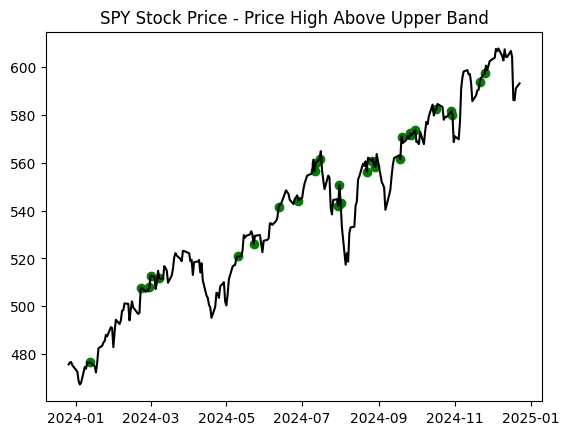

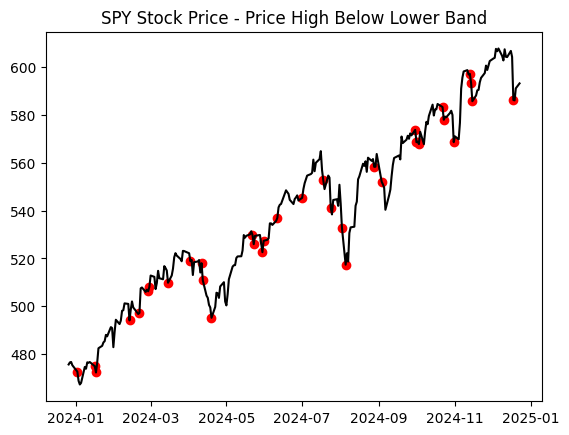

In [228]:
# Plot closing price
plt.plot(stock_data['Close'], label='Close Price', color='black')
# Plot Bollinger Bands
# plt.plot(stock_data['upper_bol_band'], label='Upper Bollinger Band', linestyle='-', color='red')
# plt.plot(stock_data['mid_bol_band'], label='Middle Bollinger Band', linestyle='-', color='green')
# plt.plot(stock_data['lower_bol_band'], label='Lower Bollinger Band', linestyle='-', color='red')
# plt.scatter(btw_upper_mid_bol_band, stock_data.loc[btw_upper_mid_bol_band, 'Close'], color = 'yellow', alpha = .5)
plt.scatter(above_upper_bol_band, stock_data.loc[above_upper_bol_band, 'Close'], color = 'green')
plt.title(f'{symbol} Stock Price - Price High Above Upper Band')
plt.show()

plt.plot(stock_data['Close'], label='Close Price', color='black')
plt.scatter(below_lower_bol_band, stock_data.loc[below_lower_bol_band, 'Close'], color = 'red')
plt.title(f'{symbol} Stock Price - Price High Below Lower Band')
plt.show()

### RSI Basic Strategy
- Extreme overbought zones ... above 70 / above 80
- Extreme oversold zones ... below 30 / below 20 
- Most likely will need to combine with various indicators / exit / entry strategies to derive statistical significance

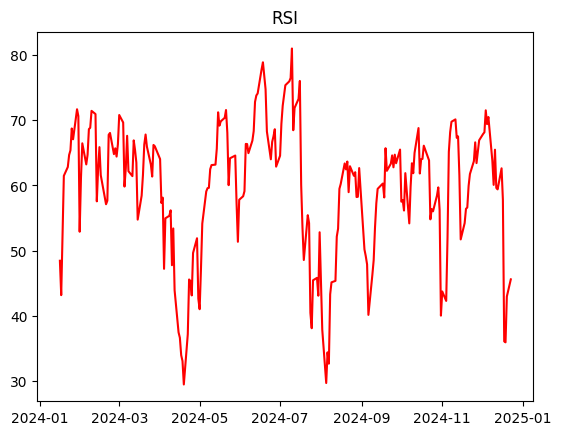

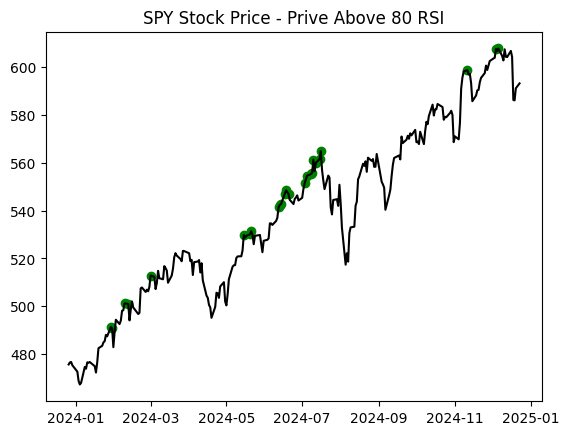

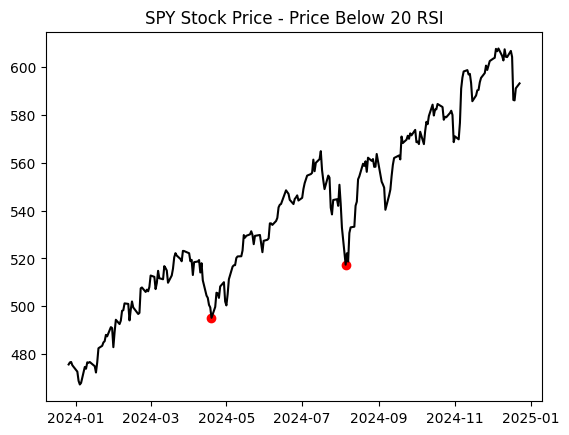

In [229]:
# Calculate Relative Strength Index (RSI)
stock_data['RSI'] = talib.RSI(stock_data['Close'], 13)

# Initialize cols with 0s
stock_data['above_overbought_RSI_70'] = 0
stock_data['above_overbought_RSI_80'] = 0
stock_data['above_overbought_RSI_90'] = 0

stock_data['below_oversold_RSI_30'] = 0
stock_data['below_oversold_RSI_20'] = 0
stock_data['below_oversold_RSI_10'] = 0


# Define logic for columns
# Find when stock Close / High is in RSI overbought zone
RSI_overbought_threshold1 = 70
RSI_overbought_threshold2 = 80
RSI_overbought_threshold3 = 90
stock_data.loc[stock_data['RSI'] >= RSI_overbought_threshold1, 'above_overbought_RSI_70'] = 1
stock_data.loc[stock_data['RSI'] >= RSI_overbought_threshold2, 'above_overbought_RSI_80'] = 1
stock_data.loc[stock_data['RSI'] >= RSI_overbought_threshold3, 'above_overbought_RSI_90'] = 1

# Find when stock Close / Low is in RSI oversold zone
RSI_oversold_threshold1 = 30
RSI_oversold_threshold2 = 20
RSI_oversold_threshold3 = 10
stock_data.loc[stock_data['RSI'] <= RSI_oversold_threshold1, 'below_oversold_RSI_30'] = 1
stock_data.loc[stock_data['RSI'] <= RSI_oversold_threshold2, 'below_oversold_RSI_20'] = 1
stock_data.loc[stock_data['RSI'] <= RSI_oversold_threshold3, 'below_oversold_RSI_10'] = 1

# Get dates of each to visualize
oversold1 = stock_data[stock_data['below_oversold_RSI_30'] == 1].index
oversold2 = stock_data[stock_data['below_oversold_RSI_20'] == 1].index
oversold3 = stock_data[stock_data['below_oversold_RSI_10'] == 1].index
overbought1 = stock_data[stock_data['above_overbought_RSI_70'] == 1].index
overbought2 = stock_data[stock_data['above_overbought_RSI_80'] == 1].index
overbought3 = stock_data[stock_data['above_overbought_RSI_90'] == 1].index

# Visualize
plt.plot(stock_data['RSI'], color = 'red')
plt.title('RSI')
plt.show()

plt.plot(stock_data['Close'], label='Close Price', color='black')
plt.scatter(overbought1, stock_data.loc[overbought1, 'Close'], color = 'green')
plt.title(f'{symbol} Stock Price - Prive Above 80 RSI')
plt.show()

plt.plot(stock_data['Close'], label='Close Price', color='black')
plt.scatter(oversold1, stock_data.loc[oversold1, 'Close'], color = 'red')
plt.title(f'{symbol} Stock Price - Price Below 20 RSI')
plt.show()

### RSI Divergence

https://www.youtube.com/watch?v=3d5RTto5fKY

In [230]:
def myRSI(price, n = 13):
    # talib.RSI uses SMA (smoothened curve)
    # this function will use actual price (to show more of the extremes)
    delta = price['Close'].diff()
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(window=n).mean()
    RolDown = dDown.rolling(window=n).mean().abs()

    RS = RolUp / RolDown
    rsi = 100 - (100 / (1 + RS))
    return rsi

stock_data['myRSI'] = myRSI(stock_data)
stock_data = stock_data.dropna()
stock_data = stock_data.reset_index()
print(stock_data.head())

        Date        Open        High         Low       Close   Adj Close  \
0 2024-01-16  475.260010  476.609985  473.059998  474.929993  468.915070   
1 2024-01-17  471.820007  472.790009  469.869995  472.290009  466.308533   
2 2024-01-18  474.010010  477.059998  472.420013  476.489990  470.455322   
3 2024-01-19  477.649994  482.720001  476.540009  482.429993  476.320099   
4 2024-01-22  484.010010  485.220001  482.779999  483.450012  477.327209   

      Volume  upper_bol_band  mid_bol_band  lower_bol_band  ...  \
0   85014900      477.875591    475.679999      473.484406  ...   
1   68843900      478.681303    475.362000      472.042696  ...   
2   91856200      478.647502    475.347998      472.048495  ...   
3  110733300      483.219266    476.563995      469.908725  ...   
4   75844900      486.571458    477.917999      469.264541  ...   

   btw_lower_mid_bol_band  below_lower_bol_band        RSI  \
0                       1                     1  48.465470   
1               

In [231]:
# Plot RSI

df_slice = stock_data[50:200]
fig = make_subplots(rows=2, cols=1)
fig.append_trace(go.Candlestick(x=df_slice.Date,
                                open = df_slice['Open'],
                                high = df_slice['High'],
                                low = df_slice['Low'],
                                close = df_slice['Close']), row=1, col=1)
fig.append_trace(go.Scatter(
    x = df_slice.Date,
    y = df_slice['RSI'],
), row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible = False)
fig.show()

### Calculating Local Extremes

In [232]:
def price_candle_id(df, candle_index, before, after):

    """
    Inputs:    
        - df = price data
        - candle = INDEX of candle of interest
        - before = len of before neighbors (5 = 5 previous candles)
        - after = len of after neighbors (5 = 5 next candles)
    Outputs:
        - Categorization of candle
            - neither (0)
            - both (1)
            - local_max (2)
            - local_min (3)
    """

    # Check if there are enough neighbors before / after candle to properly evaluate categorization (if candle is at beginning of dataset, may not have 5 before neighbors available)
    if candle_index - before < 0 or candle_index + after >= len(df):
        return 0
    
    candle_low = 1
    candle_high = 1

    # The candle is NOT a local min if it is greater than the minimum candle of its neighbors
    if df.Low[candle_index] > df.Low[candle_index - before : candle_index + after + 1].min():
        candle_low = 0
    # The candle is NOT a local max if it is less than the maximum candle of its neighbors
    if df.High[candle_index] < df.High[candle_index - before : candle_index + after + 1].max():
        candle_high = 0

    # Loop through all neighbors before and after candle to check categorization of candle
    # for i in range(candle_index - before, candle_index + after + 1):
    #     # If candle i Low is less 
    #     if(df.Low[candle_index] > df.Low[i]):
    #         candle_low = 0
    #     if(df.High[candle_index]<df.High[i]):
    #         candle_high = 0
    if candle_low and candle_high:
        return 1
    elif candle_high:
        return 2
    elif candle_low:
        return 3
    else:
        return 0

def RSI_id(df, index, before, after): 

    """
    Inputs:    
        - df = price data
        - index = INDEX of RSI value
        - before = len of before neighbors (5 = 5 previous candles)
        - after = len of after neighbors (5 = 5 next candles)
    Outputs:
        - Categorization of candle
            - neither (0)
            - both (1)
            - local_max (2)
            - local_min (3)
    """

    # Check if there are enough neighbors before / after candle to properly evaluate categorization (if candle is at beginning of dataset, may not have 5 before neighbors available)
    if index - before < 0 or index + after >= len(df):
        return 0

    local_min = 1
    local_max = 1

    # The candle is NOT a local min if it is greater than the minimum candle of its neighbors
    if df.RSI[index] > df.RSI[index - before : index + after + 1].min():
        local_min = 0
    # The candle is NOT a local max if it is less than the maximum candle of its neighbors
    if df.RSI[index] < df.RSI[index - before : index + after + 1].max():
        local_max = 0

    # for i in range(l-before, l+after+1):
    #     if(df.RSI[l]>df.RSI[i]):
    #         pividlow=0
    #     if(df.RSI[l]<df.RSI[i]):
    #         pividhigh=0
    if local_min and local_max:
        return 1
    elif local_max:
        return 2
    elif local_min:
        return 3
    else:
        return 0 

### Apply function to price data and RSI
stock_data['price_id'] = stock_data.apply(lambda x: price_candle_id(stock_data, x.name, 5, 5), axis=1)
stock_data['RSI_id'] = stock_data.apply(lambda x: RSI_id(stock_data, x.name, 5, 5), axis=1)

### Visualizing Local Extremes

In [233]:
def pointpos(x):

    """
    Functionality for visualization
        - if price row is a local min or max, store a point so we can graph later
    """

    # Gap between dot indicator of local extreme and candle
    gap = .01 * x['Close']

    if x['price_id'] == 3:
        return x['Low'] - gap
    elif x['price_id'] == 2:
        return x['High'] + gap
    else:
        return np.nan

def RSIpointpos(x):

    """
    Functionality for visualization
        - if RSI row is a local min or max, store a point so we can graph later
    """

    if x['RSI_id'] == 3:
        return x['RSI'] - 1
    elif x['RSI_id'] == 2:
        return x['RSI'] + 1
    else:
        return np.nan

# Apply functionality to create cols of visualization data
stock_data['pointpos'] = stock_data.apply(lambda row: pointpos(row), axis=1)
stock_data['RSIpointpos'] = stock_data.apply(lambda row: RSIpointpos(row), axis=1)

In [234]:
df_slice = stock_data[50:200]

fig = go.Figure(data=[go.Candlestick(x=df_slice.Date,
                open=df_slice['Open'],
                high=df_slice['High'],
                low=df_slice['Low'],
                close=df_slice['Close'])])

fig.add_scatter(x=df_slice.Date, y=df_slice['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="Local Extreme")
#fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [235]:
fig = make_subplots(rows=2, cols=1)
fig.append_trace(go.Candlestick(x=df_slice.Date,
                open=df_slice['Open'],
                high=df_slice['High'],
                low=df_slice['Low'],
                close=df_slice['Close']), row=1, col=1)

fig.add_scatter(x=df_slice.Date, y=df_slice['pointpos'], mode="markers",
                marker=dict(size=4, color="MediumPurple"),
                name="Local Extremes Price", row=1, col=1)

fig.append_trace(go.Scatter(x=df_slice.Date, y=df_slice['RSI']), row=2, col=1)
fig.add_scatter(x=df_slice.Date, y=df_slice['RSIpointpos'], mode="markers",
                marker=dict(size=4, color="Red"),
                name="Local Extremes RSI", row=2, col=1)


fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

### Creating Slopes and Looking at Divergence

In [236]:
# Window length of which local minimas / maximas are captured 
candle_window = 30

# Temp candle to consider
candle_index = 59

# Only look at the last [candle_window] number of candles before the candle index
subset = stock_data[candle_index - candle_window : candle_index + 1]

price_minimas = subset.loc[subset['price_id'] == 3, 'Low']
price_maximas = subset.loc[subset['price_id'] == 2, 'High']
RSI_minimas = subset.loc[subset['RSI_id'] == 3, 'RSI']
RSI_maximas = subset.loc[subset['RSI_id'] == 2, 'RSI']

minim = price_minimas.to_numpy()        # price minimas
xxmin = price_minimas.index.to_numpy()  # price minimas indices
maxim = price_maximas.to_numpy()        # price maximas
xxmax = price_maximas.index.to_numpy()  # price maximas indices

minimRSI = RSI_minimas.to_numpy()       # RSI minimas
xxminRSI = RSI_minimas.index.to_numpy() # RSI minimas indices
maximRSI = RSI_maximas.to_numpy()       # RSI maximas
xxmaxRSI = RSI_maximas.index.to_numpy() # RSI maximas indices

# Calculate slope and intercept of arrays by fitting with polynomial function
slmin, intercmin = np.polyfit(xxmin, minim,1)
slmax, intercmax = np.polyfit(xxmax, maxim,1)
slminRSI, intercminRSI = np.polyfit(xxminRSI, minimRSI,1)
slmaxRSI, intercmaxRSI = np.polyfit(xxmaxRSI, maximRSI,1)

# Take slice of dataframe to preview
dfpl = stock_data[candle_index - candle_window - 5 : candle_index + candle_window]
fig = make_subplots(rows=2, cols=1)
fig.append_trace(go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']), row=1, col=1)
fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=4, color="MediumPurple"),
                name="Local Extrema Price", row=1, col=1)
fig.add_trace(go.Scatter(x=xxmin, y=slmin*xxmin + intercmin, mode='lines', name='Local Minimas Slope'), row=1, col=1)
fig.add_trace(go.Scatter(x=xxmax, y=slmax*xxmax + intercmax, mode='lines', name='Local Maximas Slope'), row=1, col=1)

fig.append_trace(go.Scatter(x=dfpl.index, y=dfpl['RSI']), row=2, col=1)
fig.add_scatter(x=dfpl.index, y=dfpl['RSIpointpos'], mode="markers",
                marker=dict(size=2, color="MediumPurple"),
                name="Local Extrema RSI", row=2, col=1)
fig.add_trace(go.Scatter(x=xxminRSI, y=slminRSI*xxminRSI + intercminRSI, mode='lines', name='Local RSI Minimas Slope'), row=2, col=1)
fig.add_trace(go.Scatter(x=xxmaxRSI, y=slmaxRSI*xxmaxRSI + intercmaxRSI, mode='lines', name='Local RSI Maximas Slope'), row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

/var/folders/nf/pgqkpvdj1l9cmj9rldvv2f6c0000gn/T/ipykernel_5464/41501657.py:26: RankWarning:

Polyfit may be poorly conditioned



### Labeling Periods of Divergence

- When price is sloping up and RSI is sloping down, bearish divergence (momentum is fading on upside move)
- When price is sloping down and RSI is sloping up, bullish divergence (buying momentum may be entering market and forming local bottom)

In [237]:
def RSI_divergence_signal(candle_index, candle_window):
    
    # Take subset of dataframe (from current index looking back [candle_window] candles)
    subset = stock_data[candle_index - candle_window : candle_index + 1]

    price_minimas = subset.loc[subset['price_id'] == 3, 'Low']
    price_maximas = subset.loc[subset['price_id'] == 2, 'High']
    RSI_minimas = subset.loc[subset['RSI_id'] == 3, 'RSI']
    RSI_maximas = subset.loc[subset['RSI_id'] == 2, 'RSI']

    minim = price_minimas.to_numpy()        # price minimas
    xxmin = price_minimas.index.to_numpy()  # price minimas indices
    maxim = price_maximas.to_numpy()        # price maximas
    xxmax = price_maximas.index.to_numpy()  # price maximas indices

    minimRSI = RSI_minimas.to_numpy()       # RSI minimas
    xxminRSI = RSI_minimas.index.to_numpy() # RSI minimas indices
    maximRSI = RSI_maximas.to_numpy()       # RSI maximas
    xxmaxRSI = RSI_maximas.index.to_numpy() # RSI maximas indices

    # If there is less than 2 local extrema, can not calculate a sloping line within size of window (candle_window)
    if maxim.size < 2 or minim.size < 2 or maximRSI.size < 2 or minimRSI.size < 2:
        return 0
    
    # Calculate slope and intercept of arrays by fitting with polynomial function
    slmin, intercmin = np.polyfit(xxmin, minim,1)
    slmax, intercmax = np.polyfit(xxmax, maxim,1)
    slminRSI, intercminRSI = np.polyfit(xxminRSI, minimRSI,1)
    slmaxRSI, intercmaxRSI = np.polyfit(xxmaxRSI, maximRSI,1)
    
    # If slope of minimums and slope of maximums are increasing (higher highs/lows in price) WHILE slope of RSI max is declining (lower highs in RSI) ... BEARISH DIVERGENCE
    # Bearish Divergence = 1
    if slmin > 1e-4 and slmax > 1e-4 and slmaxRSI < -0.1:
        return 1
    # If slope of minimums and slope of maximums are declining (lower highs/lows in price) WHILE slope of RSI min is increasing (higher lows in RSI)... BULLISH DIVERGENCE
    # Bullish Divergence = 2
    elif slmin < -1e-4 and slmax < -1e-4 and slminRSI > 0.1:
        return 2
    # If neither case is true, business as usual 
    else:
        return 0
    
    ### 
    ### THINK ABOUT CASE "EXAGGERATED DIVERGENCE" --> one slope stays constant while other is moving in a direction.... volume???
    ###

# Apply divergence signal analysis to each candle index in dataframe, using a candle_window of n
window = 30

# Apply RSI divergence signal to each candle
for candle in range(0, len(stock_data)):
    stock_data.loc[candle, 'RSI_divergence_signal'] = RSI_divergence_signal(candle, window)

# Divergence signal calculated for each candle
# Candles will settle in to signal (multiple dates will exhibit the signal in a row)
print(stock_data.loc[stock_data['RSI_divergence_signal'] != 0, 'Date'])
print(stock_data['RSI_divergence_signal'].value_counts())

46   2024-03-21
47   2024-03-22
48   2024-03-25
49   2024-03-26
Name: Date, dtype: datetime64[ns]
RSI_divergence_signal
0.0    234
1.0      4
Name: count, dtype: int64


### Stochastic Oscillator
Shows short term momentum vs longer term trends - consider signal during trends

- K crosses D while above 80 to downside = downside risk
- K crosses D while below 20 to upside = upside risk
- K and D above 80 (use as momentum indicator - not recommended)
- K and D below 20 (use as momentum indicator - not recommended)

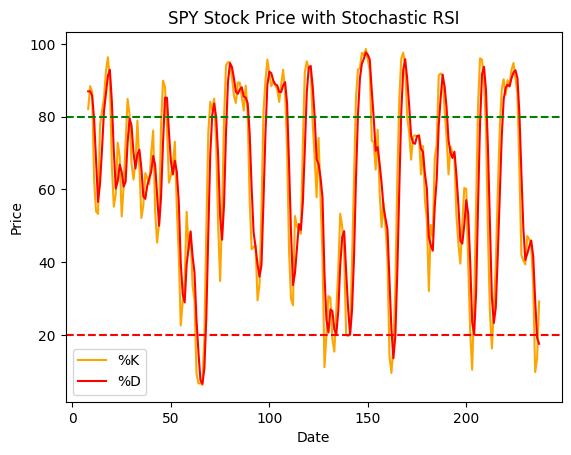

In [240]:
# Calculate Stochastic Oscillator
# window = 14, smooth window = 3 by default
stock_data['%K'], stock_data['%D'] = talib.STOCH(stock_data['High'], stock_data['Low'], stock_data['Close']) 

# Plot Stochastic RSI
plt.plot(stock_data['%K'], label='%K', linestyle='-', color='orange')
plt.plot(stock_data['%D'], label='%D', linestyle='-', color='red')
plt.axhline(80, color = 'green', linestyle = '--')
plt.axhline(20, color = 'red', linestyle = '--')
plt.title(f'{symbol} Stock Price with Stochastic RSI')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Find periods where both lines are above / below extreme zones
stock_data['above_80_stochastic'] = 0
stock_data['below_20_stochastic'] = 0

# Create cols of signals in overbought / oversold zone
stochastic_overbought_zone = 80
stochastic_oversold_zone = 20
stock_data.loc[(stock_data['%K'] >= stochastic_overbought_zone) & (stock_data['%D'] >= stochastic_overbought_zone), 'above_80_stochastic'] = 1
stock_data.loc[(stock_data['%K'] <= stochastic_oversold_zone) & (stock_data['%D'] <= stochastic_oversold_zone), 'below_20_stochastic'] = 1

In [241]:
# Calculate VWAP
stock_data['VWAP'] = (stock_data['Close'] * stock_data['Volume']).cumsum() / stock_data['Volume'].cumsum()

In [242]:
# Z Score
stock_data['Z_SCORES'] = stats.zscore(stock_data['Close'])

In [243]:
# Calculate CCI
stock_data['CCI'] = talib.CCI(stock_data['High'], stock_data['Low'], stock_data['Close'])

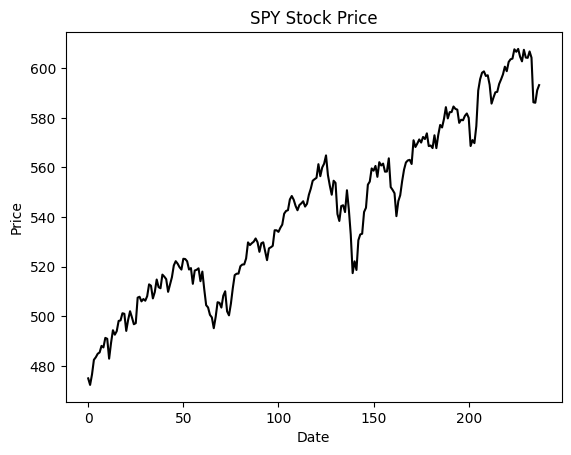

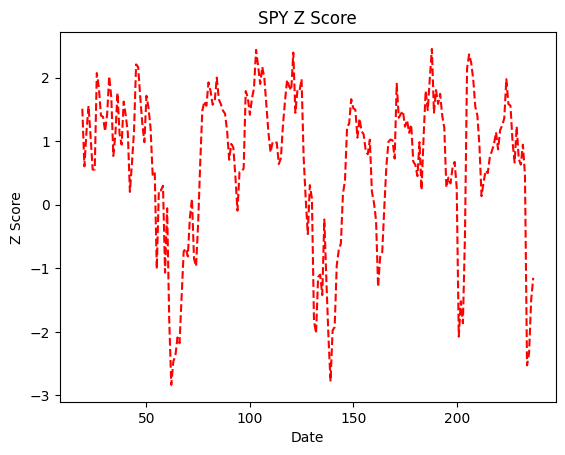

In [244]:
# Calculate Z-Score
window = 20  # Set the desired window size for the rolling calculations
stock_data['rolling_mean'] = stock_data['Close'].rolling(window=window).mean()
stock_data['rolling_std'] = stock_data['Close'].rolling(window=window).std()
stock_data['Z_Score'] = (stock_data['Close'] - stock_data['rolling_mean']) / stock_data['rolling_std']

# Plot Z-Score
plt.plot(stock_data['Close'], label='Price', linestyle='-', color='black')
plt.title(f'{symbol} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

plt.plot(stock_data['Z_Score'], label='Z Score', linestyle='--', color='red')
plt.title(f'{symbol} Z Score')
plt.xlabel('Date')
plt.ylabel('Z Score')
plt.show()

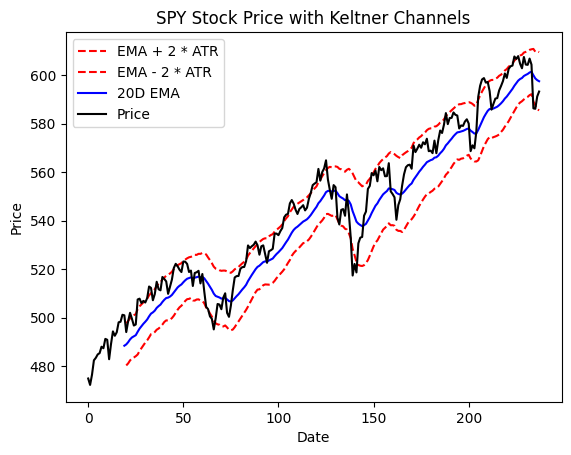

In [245]:
# Calculate Keltner
period = 20
multiplier = 2
stock_data['20 EMA'] = talib.EMA(stock_data['Close'], period)
stock_data['ATR'] = talib.ATR(stock_data['High'], stock_data['Low'], stock_data['Close'], period)
stock_data['Keltner Upper Band'] = stock_data['20 EMA'] + multiplier * stock_data['ATR']
stock_data['Keltner Lower Band'] = stock_data['20 EMA'] - multiplier * stock_data['ATR']

# Plot Keltner
plt.plot(stock_data['Keltner Upper Band'], label='EMA + 2 * ATR', linestyle='--', color='red')
plt.plot(stock_data['Keltner Lower Band'], label='EMA - 2 * ATR', linestyle='--', color='red')
plt.plot(stock_data['20 EMA'], label='20D EMA', linestyle='-', color='blue')
plt.plot(stock_data['Close'], label='Price', linestyle='-', color='black')
plt.title(f'{symbol} Stock Price with Keltner Channels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [246]:
# Average True Range

In [247]:
# https://www.youtube.com/watch?v=3d5RTto5fKY --> Complex RSI divergence strategy
# Basic from Google below

def calculate_divergence(price_data, indicator_data):
    """
    Calculates bullish and bearish divergences between price and an indicator.

    Args:
        price_data (pd.Series): Price data (e.g., closing prices).
        indicator_data (pd.Series): Indicator data (e.g., RSI, MACD).

    Returns:
        pd.DataFrame: A dataframe with divergence signals.
    """

    divergence = pd.DataFrame(index=price_data.index)
    divergence['Price'] = price_data
    divergence['Indicator'] = indicator_data

    # Find peaks and troughs in price and indicator
    divergence['Price_Peaks'] = price_data.where(price_data > price_data.shift(1))
    divergence['Price_Troughs'] = price_data.where(price_data < price_data.shift(1))
    divergence['Indicator_Peaks'] = indicator_data.where(indicator_data > indicator_data.shift(1))
    divergence['Indicator_Troughs'] = indicator_data.where(indicator_data < indicator_data.shift(1))

    # Identify bullish divergence
    divergence['Bullish'] = np.where(
        (divergence['Price_Troughs'] < divergence['Price_Troughs'].shift(1)) &
        (divergence['Indicator_Troughs'] > divergence['Indicator_Troughs'].shift(1)),
        1, 0
    )

    # Identify bearish divergence
    divergence['Bearish'] = np.where(
        (divergence['Price_Peaks'] > divergence['Price_Peaks'].shift(1)) &
        (divergence['Indicator_Peaks'] < divergence['Indicator_Peaks'].shift(1)),
        1, 0
    )

    return divergence